In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
import numpy as np
from typing import Optional, Callable
import os
import matplotlib.pyplot as plt

from scripts.loops import train_loop, valid_loop, test_loop
from scripts.dataset_template import DatasetTemplate
from scripts.models.autoencoder_cnn import CNNAutoencoder
from scripts.models.autoencoder_lin import LinearAutoencoder
from scripts.models.autoencoder_lstm import LSTMAutoencoder
import pandas as pd

In [2]:
#check if cuda available

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda


In [3]:
torch.manual_seed(0)
np.random.seed(0)


In [4]:
#paths
path_data_main = "Data_abs_only"

data_train_path = f"/home/bolci/Documents/Projekty/5G_OPEN_RAN/Anomaly_detection/5G_Open_RAN/{path_data_main}/Data_channels/train/comeretial"
data_test_folder_path = f"/home/bolci/Documents/Projekty/5G_OPEN_RAN/Anomaly_detection/5G_Open_RAN/{path_data_main}/Data_channels/test"
data_valid_folder_path = f"/home/bolci/Documents/Projekty/5G_OPEN_RAN/Anomaly_detection/5G_Open_RAN/{path_data_main}/Data_channels/valid"

testing_folders = os.listdir(data_test_folder_path)
valid_folders = os.listdir(data_valid_folder_path)

In [5]:
def save_file(file_name, values):
    with open(file_name, "w") as output:
        output.write(str(values))

In [6]:
#hyperparameters
batch_size = 32
batch_size_test_valid = 1
learning_rate = 0.001
epochs = 200

In [7]:
#transforms
data_transforms = transforms.Compose([transforms.ToTensor()])

In [8]:
saving_path = '/home/bolci/Documents/Projekty/5G_OPEN_RAN/Anomaly_detection/5G_Open_RAN/scripts/Results/'

In [12]:
def valid_data(data_loader, model, loss):
    losses = []
    with torch.no_grad():
        for x,y in data_loader:
            pred = model(x.to(device))
            test_loss = loss(pred, y.to(device)).item()

            losses.append(test_loss)

    return np.asarray(losses)


def check_threshold(data_loader_true, data_loader_false, model, criteria, threshols_range = range(1,30), koeficient = 0.001):
    losses_true = valid_data(data_loader_true, model, criteria)
    losses_false = valid_data(data_loader_false, model, criteria)

    
    no_samples_true = len(losses_true)
    no_samples_false = len(losses_false)
    print(no_samples_true)
    print(no_samples_false)

    thresholds = []
    all_accuracy_false = []
    all_accuracy_true = []
    all_accuracy_all = []

    for single_threshold in threshols_range:
        threshold_all = single_threshold*koeficient

        all_true = np.where(losses_true < threshold_all)
        all_false = np.where(losses_false > threshold_all)

        no_true = len(all_true[0])
        no_false = len(all_false[0])
        

        accuracy_true = (no_true)/no_samples_true
        accuracy_false = (no_false)/no_samples_false
        accuracy_all = (no_true + no_false)/(no_samples_true + no_samples_false)
        
        thresholds.append(threshold_all)
        all_accuracy_true.append(accuracy_true)
        all_accuracy_false.append(accuracy_false)
        all_accuracy_all.append(accuracy_all)

    return thresholds, all_accuracy_true, all_accuracy_false, all_accuracy_all



Avg loss: 0.492267 

Epoch 1
-------------------------------
loss: 0.340375  [    0/163420]

loss: 0.044124  [32000/163420]

loss: 0.034862  [64000/163420]

loss: 0.029145  [96000/163420]

loss: 0.026173  [128000/163420]

loss: 0.022855  [160000/163420]

------------- TRUE BTS SCORE ----------------
Avg loss: 0.022283 

------------- FALSE BTS SCORE ----------------
Avg loss: 0.023717 

Epoch 2
-------------------------------
loss: 0.024958  [    0/163420]

loss: 0.022394  [32000/163420]

loss: 0.019583  [64000/163420]

loss: 0.019322  [96000/163420]

loss: 0.018495  [128000/163420]

loss: 0.019589  [160000/163420]

------------- TRUE BTS SCORE ----------------
Avg loss: 0.015277 

------------- FALSE BTS SCORE ----------------
Avg loss: 0.014139 

Epoch 3
-------------------------------
loss: 0.016282  [    0/163420]

loss: 0.017693  [32000/163420]

loss: 0.015779  [64000/163420]

loss: 0.015354  [96000/163420]

loss: 0.015792  [128000/163420]

loss: 0.015602  [160000/163420]

-------

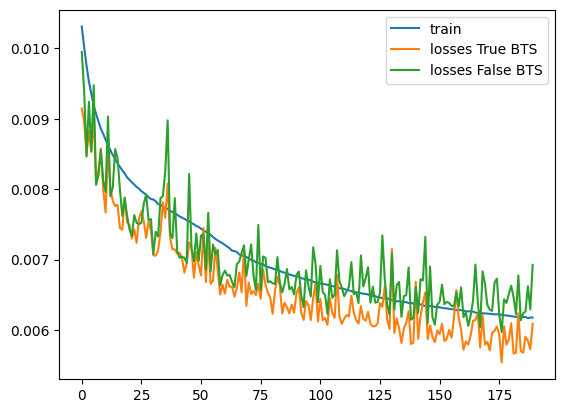

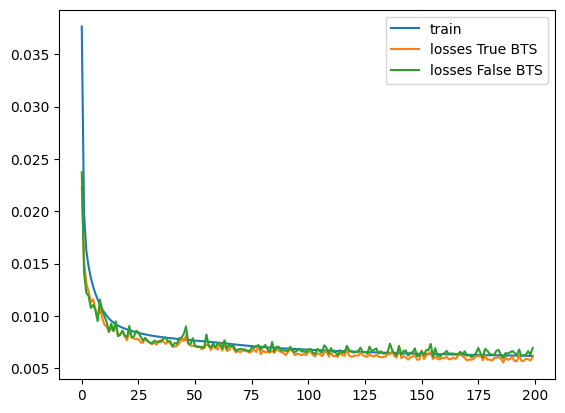

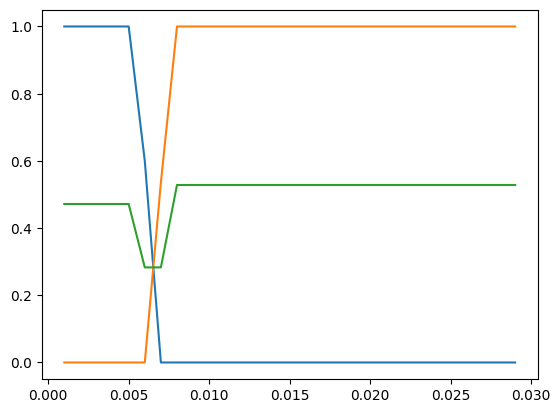

In [10]:
#datasets and dataloaders


b_s = [32]
learnin_rt = [0.001]

for batch_size in b_s:
    for learning_rate in learnin_rt:

        folder_name = F"results_batch-size={batch_size}_learning-rate={learning_rate}"
        saving_path_with_folder = os.path.join(saving_path, folder_name)
        
        if not os.path.exists(saving_path_with_folder):
            os.makedirs(saving_path_with_folder)

        #train
        train_dataset = DatasetTemplate(data_train_path, 0, transform = data_transforms)
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        #valid
        valid_datasets = {}
        valid_dataloaders = {}
        
        for valid_folder_name in valid_folders:
            valid_folder_path_all = os.path.join(data_valid_folder_path, valid_folder_name)
            valid_datasets[valid_folder_name] = DatasetTemplate(valid_folder_path_all, 1)
            valid_dataloaders[valid_folder_name] = DataLoader(valid_datasets[valid_folder_name], batch_size=batch_size, shuffle=True)
        
        #test
        test_datasets = {}
        test_dataloaders = {}
        
        for test_folder_name in testing_folders:
            test_folder_path_all = os.path.join(data_test_folder_path, test_folder_name)
            test_datasets[test_folder_name] = DatasetTemplate(test_folder_path_all, 1)
            test_dataloaders[test_folder_name] = DataLoader(test_datasets[test_folder_name], batch_size=batch_size_test_valid, shuffle=True)


        #define model
        model = CNNAutoencoder().to(device)
        criterion = nn.MSELoss()
        loss_RMS = lambda x,y: torch.sqrt(criterion(x, y))
        metric_fn_RMS = lambda x,y: torch.sqrt(criterion(x, y))
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        #for x,x in train_dataloader:
        #    print(model(x.to('cuda')).shape)
        
        
        valid_loop(test_dataloaders[list(test_dataloaders.keys())[0]],
                  model,
                  loss_RMS,
                  metric_fn_RMS,
                  device=device)


        #epochs

        # Lists to log the losses during the training process
        train_losses = []
        
        valid_losses_true = []
        valid_metrics_true = []
        
        valid_losses_false = []
        valid_metrics_false = []
        
        for t in range(epochs):
          print(f"Epoch {t+1}\n-------------------------------")
          train_loss = train_loop(train_dataloader,
                                             model,
                                             loss_RMS,
                                             optimizer)
        
          print("------------- TRUE BTS SCORE ----------------")
          valid_loss_true, valid_metric_true = valid_loop(valid_dataloaders['Fake_Bts_PCI_466'],
                                                          model,
                                                          loss_RMS,
                                                          metric_fn_RMS)
        
          print("------------- FALSE BTS SCORE ----------------")
          valid_loss_false, valid_metric_false = valid_loop(valid_dataloaders['Fake_Bts_PCI_466_wPA'],
                                                            model,
                                                            loss_RMS,
                                                            metric_fn_RMS)
            
        
          train_losses.append(train_loss)
        
          valid_losses_true.append(valid_loss_true)
          valid_metrics_true.append(valid_metric_true)
        
          valid_losses_false.append(valid_loss_false)
          valid_metrics_false.append(valid_metric_false)
            
        
        print("Done!")

        model_save = 'model.pt'
        saving_path_model = os.path.join(saving_path_with_folder, model_save)
        torch.save(model.state_dict(), saving_path_model)

        saving_path_figure = os.path.join(saving_path_with_folder, 'fig_1.png')
        plt.figure()
        plt.plot(train_losses[10:], label="train")
        plt.plot(valid_losses_true[10:], label="losses True BTS")
        plt.plot(valid_losses_false[10:], label="losses False BTS")
        plt.legend()
        plt.savefig(saving_path_figure)

        saving_path_figure = os.path.join(saving_path_with_folder, 'fig_2.png')
        plt.figure()
        plt.plot(train_losses, label="train")
        plt.plot(valid_losses_true, label="losses True BTS")
        plt.plot(valid_losses_false, label="losses False BTS")
        plt.legend()
        plt.savefig(saving_path_figure)

        
        #saving scores
        train_saving_path = os.path.join(saving_path_with_folder, 'train_scores.txt')
        save_file(train_saving_path, train_losses)

        validT_saving_path = os.path.join(saving_path_with_folder, 'valid_true_scores.txt')
        save_file(validT_saving_path, valid_losses_true)

        validF_saving_path = os.path.join(saving_path_with_folder, 'valid_false_scores.txt')
        save_file(validF_saving_path, valid_losses_false)

        
        for testing_name, testing_loader in test_dataloaders.items():
            test_losses, test_metrics = test_loop(testing_loader, 
                                                    model,
                                                    loss_RMS,
                                                     metric_fn_RMS)

            #saving_scores
            validF_saving_path = os.path.join(saving_path_with_folder, f'Ftest_{testing_name}_scores.txt')
            save_file(validF_saving_path, test_losses)
            
            mean_loss = np.mean(np.array(test_losses))
            mean_metrics = np.mean(np.array(test_metrics))
            print(f"Dataset name: {testing_name}, mean_loss: {mean_loss}, mean_acc: {mean_metrics}")

        measured_threshold = check_threshold(valid_dataloaders['Fake_Bts_PCI_466'], valid_dataloaders['Fake_Bts_PCI_466_wPA'], model, loss_RMS)

        plt.figure()
        plt.plot(measured_threshold[0], measured_threshold[1])
        plt.plot(measured_threshold[0], measured_threshold[2])
        plt.plot(measured_threshold[0], measured_threshold[3])

        

                

In [11]:
for k,v in scores.items():
    print(k)
    print(len(v))

NameError: name 'scores' is not defined

25
28


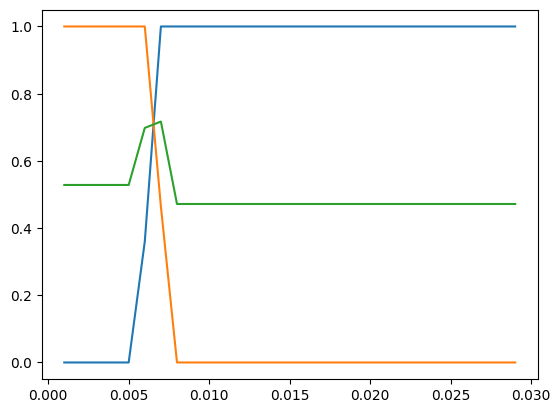

In [29]:
measured_threshold = check_threshold(valid_dataloaders['Fake_Bts_PCI_466'], valid_dataloaders['Fake_Bts_PCI_466_wPA'], model, loss_RMS)

plt.figure()
plt.plot(measured_threshold[0], measured_threshold[1], label = 'true _per ratio')
plt.plot(measured_threshold[0], measured_threshold[2], label = 'false _per ratio')
plt.plot(measured_threshold[0], measured_threshold[3], label = 'total')

734
784


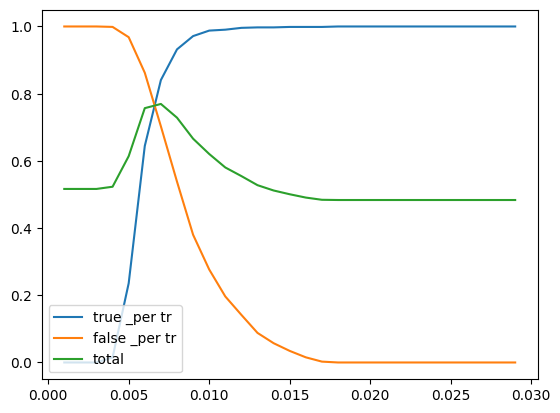

In [31]:
measured_threshold = check_threshold(test_dataloaders['Fake_Bts_PCI_466_traffic'],test_dataloaders['Fake_Bts_PCI_466_wPA_traffic'], model, loss_RMS)

plt.figure()
plt.plot(measured_threshold[0], measured_threshold[1], label = 'true _per tr')
plt.plot(measured_threshold[0], measured_threshold[2], label = 'false _per tr')
plt.plot(measured_threshold[0], measured_threshold[3], label = 'total')
plt.legend()

1534
1530


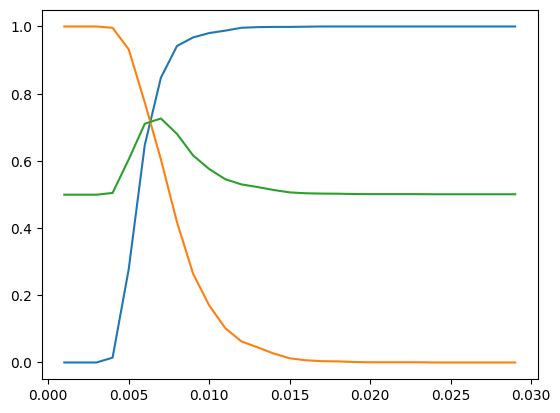

In [28]:
measured_threshold = check_threshold( test_dataloaders['Fake_Bts_PCI_12'],test_dataloaders['Fake_Bts_PCI_12_wPA'], model, loss_RMS)

plt.figure()
plt.plot(measured_threshold[0], measured_threshold[1], label = 'true _per ratio')
plt.plot(measured_threshold[0], measured_threshold[2], label = 'false _per ratio')
plt.plot(measured_threshold[0], measured_threshold[3], label = 'total')